In [ ]:
import numpy as np
import pickle
import time
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




Datasets successfully loaded.


Training/validation on 32450 samples (25 CCLs x 1298 DepOIs) and testing on 3894 samples (3 CCLs x 1298 DepOIs).


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.4234 - val_loss: 0.1283
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0900 - val_loss: 0.0844
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0577 - val_loss: 0.0684
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0476 - val_loss: 0.0691
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0441 - val_loss: 0.0616
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0413 - val_loss: 0.0585
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0395 - val_loss: 0.0657
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0382 - val_loss: 0.0655
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0362 - val_loss: 0.0551
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0347 - val_loss: 0.0569


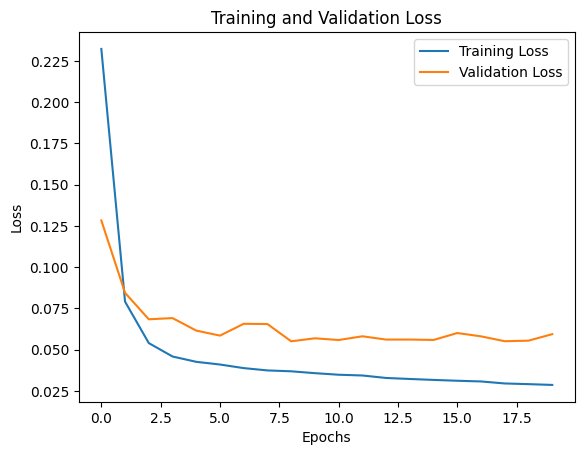


Evaluation metrics on test data:
MSE: 0.0415
RMSE: 0.2036
R-squared (R2): 0.7758
MAE: 0.1504
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Evaluation metrics on validation data:
MSE: 0.0298
RMSE: 0.1726
R-squared (R2): 0.8417
MAE: 0.1249


In [ ]:
if __name__ == '__main__':

    # Loading data
    with open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/ccl_complete_data_28CCL_1298DepOI_36344samples_demo.pickle', 'rb') as f:
        data_mut, data_exp, data_cna, data_meth, data_dep, data_fprint = pickle.load(f)

    # Loading pretrained models
    premodel_mut = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/premodel_tcga_mut_1000_100_50.pickle', 'rb'))
    premodel_exp = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/premodel_tcga_exp_500_200_50.pickle', 'rb'))
    premodel_cna = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/premodel_tcga_cna_500_200_50.pickle', 'rb'))
    premodel_meth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Thesis/data/premodel_tcga_meth_500_200_50.pickle', 'rb'))
    print("\n\nDatasets successfully loaded.")


    # model parameters
    activation_func = 'relu' 
    activation_func2 = 'linear' 
    init = 'he_uniform'
    dense_layer_dim = 250
    batch_size = 500
    num_epoch = 20
    num_DepOI = 1298 
    num_ccl = int(data_mut.shape[0]/num_DepOI)


    id_rand = np.random.permutation(num_ccl)
    id_cell_train = id_rand[np.arange(0, round(num_ccl*0.9))]
    id_cell_test = id_rand[np.arange(round(num_ccl*0.9), num_ccl)]

    id_train = np.arange(0, 1298) + id_cell_train[0]*1298
    for y in id_cell_train:
        id_train = np.union1d(id_train, np.arange(0, 1298) + y*1298)
    id_test = np.arange(0, 1298) + id_cell_test[0] * 1298
    for y in id_cell_test:
        id_test = np.union1d(id_test, np.arange(0, 1298) + y*1298)
    print("\n\nTraining/validation on {} samples ({} CCLs x {} DepOIs) and testing on {} samples ({} CCLs x {} DepOIs).\n\n".format(
        len(id_train), len(id_cell_train), num_DepOI, len(id_test), len(id_cell_test), num_DepOI))

   
    t = time.time()

    # subnetwork of mutations
    input_mut = Input(shape=(premodel_mut[0][0].shape[0],))  
    x = layers.Dense(1000, activation=activation_func, kernel_initializer=init, trainable=True)(input_mut)
    x = layers.Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)

    model_mut = models.Model(input_mut, x)
    model_mut.layers[1].set_weights(premodel_mut[0])
    model_mut.layers[2].set_weights(premodel_mut[1])  
    model_mut.layers[3].set_weights(premodel_mut[2])

    # subnetwork of expression
    input_exp = Input(shape=(premodel_exp[0][0].shape[0],))  
    x = layers.Dense(500, activation=activation_func, kernel_initializer=init, trainable=True)(input_exp)
    x = layers.Dense(200, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)


    model_exp = models.Model(input_exp, x)
    model_exp.layers[1].set_weights(premodel_exp[0])
    model_exp.layers[2].set_weights(premodel_exp[1]) 
    model_exp.layers[3].set_weights(premodel_exp[2])

    # subnetwork of copy number alterations
    input_cna = Input(shape=(data_cna.shape[1],))
    x = layers.Dense(500, activation=activation_func, kernel_initializer=init, trainable=True)(input_cna)
    x = layers.Dense(200, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)

    model_cna = models.Model(input_cna, x)
    model_cna.layers[1].set_weights(premodel_cna[0])
    model_cna.layers[2].set_weights(premodel_cna[1])
    model_cna.layers[3].set_weights(premodel_cna[2])

    # subnetwork of Methylation methylations
    input_meth = Input(shape=(premodel_meth[0][0].shape[0],))
    x = layers.Dense(500, activation=activation_func, kernel_initializer=init, trainable=True)(input_meth)
    x = layers.Dense(200, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)

    model_meth = models.Model(input_meth, x)
    model_meth.layers[1].set_weights(premodel_meth[0])
    model_meth.layers[2].set_weights(premodel_meth[1])
    model_meth.layers[3].set_weights(premodel_meth[2])

    # subnetwork of gene fingerprints
    input_gene = Input(shape=(data_fprint.shape[1],))
    x = layers.Dense(1000, activation=activation_func, kernel_initializer=init, trainable=True)(input_gene)
    x = layers.Dense(100, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    x = layers.Dense(50, activation=activation_func, kernel_initializer=init, trainable=True)(x)

    model_gene = models.Model(input_gene, x)


   # Merging subnetworks
    merged = layers.concatenate([model_exp.output, model_meth.output, model_gene.output])
    x = layers.Dense(dense_layer_dim, activation=activation_func, kernel_initializer=init, trainable=True)(merged)
    x = layers.Dense(dense_layer_dim, activation=activation_func, kernel_initializer=init, trainable=True)(x)
    output = layers.Dense(1, activation=activation_func2, kernel_initializer=init, trainable=True)(x)

    model_final = models.Model(inputs=[model_mut.input, model_exp.input, model_cna.input, model_meth.input, model_gene.input], outputs=output)

    # Compile and train the model
    optimizer = Adam(learning_rate=0.00008) 
    model_final.compile(loss='mse', optimizer=optimizer)

    history = model_final.fit(
        [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
        data_dep[id_train], epochs=num_epoch, validation_split=1/9, batch_size=batch_size, shuffle=True, verbose=1)

    y_pred = model_final.predict(
        [data_mut[id_test], data_exp[id_test], data_cna[id_test], data_meth[id_test], data_fprint[id_test]],
        batch_size=batch_size)

    mse = mean_squared_error(data_dep[id_test], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(data_dep[id_test], y_pred)
    mae = mean_absolute_error(data_dep[id_test], y_pred)


    # Plotting training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.xlim(0.0, 5.0)
    # plt.ylim(0.0, 5.0)
    plt.legend()
    plt.show()

    print(f"\nEvaluation metrics on test data:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")
    print(f"MAE: {mae:.4f}")

    #validation metrics
   
    val_predictions = model_final.predict(
        [data_mut[id_train], data_exp[id_train], data_cna[id_train], data_meth[id_train], data_fprint[id_train]],
        batch_size=batch_size)

    val_mse = mean_squared_error(data_dep[id_train], val_predictions)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(data_dep[id_train], val_predictions)
    val_mae = mean_absolute_error(data_dep[id_train], val_predictions)

    # Printing evaluation metrics for validation data
    print(f"\nEvaluation metrics on validation data:")
    print(f"MSE: {val_mse:.4f}")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"R-squared (R2): {val_r2:.4f}")
    print(f"MAE: {val_mae:.4f}")

